[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fanzheng10/HiDeF/blob/master/analysis/protein_interaction_network_app.ipynb)


# Install dependencies

In [ ]:
!pip install dash  &> /dev/null
!pip install dash-cytoscape  &> /dev/null
!pip install jupyter-dash  &> /dev/null
!apt-get -qq install -y graphviz && pip install pydot  &> /dev/null

In [ ]:
import os
os.chdir('/content/drive/MyDrive/HiDeF')
!python setup.py install  &> /dev/null

In [ ]:
import os, sys
import pandas as pd
import json
import networkx as nx

In [ ]:
import dash
import dash_cytoscape as cyto
from dash import html
from jupyter_dash import JupyterDash
from dash import dcc
from dash.dependencies import Input, Output, State
# import jupyter_dash, pydot

In [ ]:
from hidef import *
from hidef.dash_utils import *

# A simple model

@> initializing the graph...
INFO:hidef:initializing the graph...
@> graph initialized in 0.02s
DEBUG:hidef:graph initialized in 0.02s
@> removing redudant edges...
INFO:hidef:removing redudant edges...
@> redundant edges removed in 0.00s
DEBUG:hidef:redundant edges removed in 0.00s
@> attaching terminal nodes to the graph...
INFO:hidef:attaching terminal nodes to the graph...
@> terminal nodes attached in 0.00s
DEBUG:hidef:terminal nodes attached in 0.00s
@> propagate terminal node assignments upward in the hierarchy
INFO:hidef:propagate terminal node assignments upward in the hierarchy
@> terminal nodes propagated in 0.01s
DEBUG:hidef:terminal nodes propagated in 0.01s
@> finding secondary edges...
INFO:hidef:finding secondary edges...
@> secondary edges found in 0.01s
DEBUG:hidef:secondary edges found in 0.01s


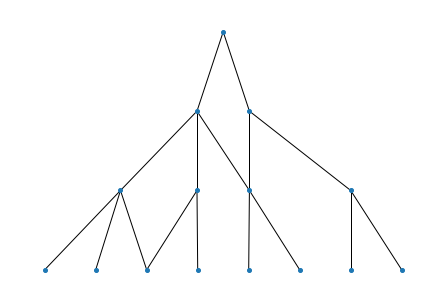

In [ ]:
P = ['11111111',
  '11111100',
  '00001111',
  '11100000',
  '00110000',
  '00001100',
  '00000011']

wv = weaver.Weaver()
H = wv.weave(P, cutoff=1.0)
Hv = wv.show()

Use dash_cytoscape to create a more dynamic network visualization

In [ ]:
app = JupyterDash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape',
        elements=hier_digraph_to_dash(H, Hv[1]),
        layout={'name': 'breadthfirst',
                'roots': '[id = "0-0"]'}
    )
])
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

In [ ]:
# TODO: this should be a function
app = JupyterDash(__name__)
app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape',
        elements=hier_digraph_to_dash(wv, Hv[1], True),
        layout={'name': 'breadthfirst',
                'roots': '[id = "0-0"]'}
    )
])
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

Add a panel to show node data

In [ ]:
app = JupyterDash(__name__)

styles = {
    'json-output': {
        'overflow-y': 'scroll',
        'height': 'calc(100% - 25px)',
        'border': 'thin lightgrey solid'
    },
    'tab': {'height': 'calc(98vh - 115px)'}
}

app.layout = html.Div([
  html.Div([
      cyto.Cytoscape(
          id='cytoscape',
          elements=hier_digraph_to_dash(wv, Hv[1], True, True),
          layout={'name': 'breadthfirst',
                  'roots': '[id = "0-0"]'}
      )
  ]),
  html.Div(className='four columns', children=[
      dcc.Tab(label='Mouseover Data', children=[
          html.Div(style=styles['tab'], children=[
              html.P('Node Data JSON:'),
              html.Pre(
                  id='mouseover-node-data-json-output',
                  style=styles['json-output']
              )
          ])
      ]),
  ])
],style={'display': 'flex', 'flex-direction': 'row'})

@app.callback(Output('mouseover-node-data-json-output', 'children'),
              [Input('cytoscape', 'tapNodeData')])
def displayMouseoverNodeData(data):
    return json.dumps(data, indent=2)

app.run_server(mode='inline')


<IPython.core.display.Javascript object>

# Use a real-world PPI model (BioPlex 2.0)


In [ ]:
os.chdir('/content/drive/MyDrive/HiDeF/examples')
df_net = pd.read_csv('BioPlex.tsv', header=None, sep='\t')
df_net.head()

,0,1
0,UBE2Q1,SRPRB
1,UBE2Q1,LYPD3
2,UBE2Q1,C1QTNF2
3,UBE2Q1,C3AR1
4,UBE2Q1,TCEAL1


In [ ]:
if not os.path.isfile('BioPlex.gml'):
  os.system('./test.sh')

H_bioplex = nx.read_gml('BioPlex.gml')

# this runs HiDeF on BioPlex2.0; takes less than 1min

## Main server for PPI hierarchies

In [ ]:
H = H_bioplex
H_spec_df = get_hier_specs(H)

styles = {
    'json-output': {
        'overflow-y': 'scroll',
        'overflow-x': 'scroll',
        'height': 'calc(75% - 25px)',
        'border': 'thin lightgrey solid'
    },
    'tab': {'height': 'calc(98vh - 115px)'}
}

default_stylesheet = [
    {
        "selector": 'node',
        'style': {
            "opacity": 0.9,
            "label": "data(label)",
        }
    },
    {
        "selector": 'edge',
        'style': {
            "line-color": 'grey',
            "opacity": 0.3,
        }
    },
]

app = JupyterDash(__name__)
app.layout = html.Div([
  html.Div([
    html.H3('The Hierarchical Model'),
    cyto.Cytoscape(
        id='hier',
        elements=hier_digraph_to_dash(H, add_node_data=True),
        layout={'name': 'cose'},
        stylesheet = default_stylesheet
    ) 
  ], style={'margin-right':'50px', 'margin-left':'10px'}),
  html.Div([
    html.H3('The Sub-network of the Selected Module'),
    cyto.Cytoscape(
        id='subnet',
        elements=subnet_to_dash(df_net, []),
        layout={'name': 'cose'},
        stylesheet = default_stylesheet
    ) 
  ], id='subnet-text',style={'margin-right':'50px', 'width':'30%'}),
  html.Div(className='four columns',children=[
      dcc.Tabs(id='tabs', children=[
        dcc.Tab(label='Control Panel', children = [
  
            html.H4('Highlight by Range of Module Persistence'),
            html.Div(children=[
                html.P('Min: '),
                dcc.Input(id='persistence-min',
                          type='number',
                          min=H_spec_df['Persistence'].min(),
                          max=H_spec_df['Persistence'].max(),
                          value=H_spec_df['Persistence'].min(), style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px','margin-right': '5px'}),
                html.P('Max: '),
                dcc.Input(id='persistence-max',
                          type='number',
                          min=H_spec_df['Persistence'].min(),
                          max=H_spec_df['Persistence'].max(),
                          value=H_spec_df['Persistence'].max(), style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px'})

              ], style={'display': 'flex'}
            ),
            
            html.H4('Highlight by Range of Module Size'),
            html.Div(children=[
                html.P('Min: '),
                dcc.Input(id='size-min',
                          type='number',
                          min=H_spec_df['Size'].min(),
                          max=H_spec_df['Size'].max(),
                          value=H_spec_df['Size'].min(), style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px', 'margin-right': '5px'}),
                html.P('Max: '),
                dcc.Input(id='size-max',
                          type='number',
                          min=H_spec_df['Size'].min(),
                          max=H_spec_df['Size'].max(),
                          value=H_spec_df['Size'].max(), style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px'})
                ], style={'display': 'flex'}
            ),              

            html.H4('Upper Limit of Module Size for Sub-network Visualization'),
            dcc.Input(id='max-size-for-subnet',
                          type='number',
                          min=H_spec_df['Size'].min(),
                          max=H_spec_df['Size'].max(),
                          value=100, style={'height':'75%'}),

            html.H4('Node Size'),
            html.Div(children=[
                html.P('Hierarchy:'),
                dcc.Input(id='nodesize-hier',
                          type='number',
                          min=1, value=15, 
                          style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px', 'margin-right': '5px'}),

                html.P('Sub-network:'),
                dcc.Input(id='nodesize-subnet',
                          type='number',
                          min=1, value=15, 
                          style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px', 'margin-right': '5px'}),
                ], style={'display': 'flex'}
            ),

            html.H4('Label Size'),
            html.Div(children=[
                html.P('Hierarchy:'),
                dcc.Input(id='labelsize-hier',
                          type='number',
                          min=1, value=15, 
                          style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px', 'margin-right': '5px'}),

                html.P('Sub-network:'),
                dcc.Input(id='labelsize-subnet',
                          type='number',
                          min=1, value=10, 
                          style={'height':'75%', 'margin-top': '15px', 'margin-left': '5px', 'margin-right': '5px'}),
                ], style={'display': 'flex'}
            )
        ]),
        dcc.Tab(label='Module Data', children=[
          html.Div(style=styles['tab'], children=[
              html.P('Selected Module Data JSON:'),
              html.Pre(
                  id='node-data-json-output',
                  style=styles['json-output']
              )
          ])
        ])
      ])                                              
  ], style={'width': '25%'})

],
style={'display': 'flex', 'flex-direction': 'row'}
)

@app.callback(Output('subnet-text', 'children'),
              Input('hier', 'tapNodeData'),
               Input('max-size-for-subnet', 'value'),
              State('subnet-text', 'children'))
def update_subnet_elements(data, size_limit, elements): # make the subnet respond to the node selection in the main hierarchy
  if data == None:
    node_names_new = []
    children = [
      html.H3('The Sub-network of the Selected Module'),
      html.P('Select a node to visualize the sub-network')
     ]
    return children
  else:
    node_names_new = data['MemberList'].split()
  if len(node_names_new) <= size_limit:
      elements = subnet_to_dash(df_net, node_names_new)
      children = [
        html.H3('The Sub-network of the Selected Module'),
        cyto.Cytoscape(
            id='subnet',
            elements=elements,
            layout={'name': 'cose'},
            stylesheet = default_stylesheet
        )
      ]
  else:
     children = [
      html.H3('The Sub-network of the Selected Module'),
      html.P('Warning: the selected module is large and rendering its sub-network could be slow. If you want to proceed, increase the "upper limit of module size" in the control panel')
     ]
  return children


@app.callback(Output('node-data-json-output', 'children'),
              [Input('hier', 'selectedNodeData')])
def displayMousetapNodeData(data):
  return json.dumps(data, indent=2)


@app.callback(Output('hier', 'stylesheet'), # note 'stylesheet' needs to be declared in 'hier'
              Input('size-min', 'value'),
              Input('size-max', 'value'),
              Input('persistence-min', 'value'),
              Input('persistence-max', 'value'),
              Input('nodesize-hier', 'value'),
              Input('labelsize-hier', 'value'),
              State('hier', 'stylesheet'))
def hier_styles(size_min, size_max, pers_min, pers_max, node_size, label_size, hier_stylesheet):
  stylesheet = hier_stylesheet
  df_unsel = H_spec_df.loc[(H_spec_df['Persistence'] < pers_min) |
                         (H_spec_df['Persistence'] > pers_max) |
                         (H_spec_df['Size'] < size_min) | 
                         (H_spec_df['Size'] > size_max), :]
  unsel_nodes = df_unsel.index.tolist()
  for node in unsel_nodes:
    stylesheet.append({
          "selector": 'node[id="{}"]'.format(node),
          "style": {
              'background-color': 'grey',
              'opacity': 0.3,
              'label': ""
          }
    })
  stylesheet.append({
      "selector": "node",
      "style": {
          "font-size" : label_size,
          "width" : node_size,
          "height": node_size
      }
  })
  return stylesheet


@app.callback(Output('subnet', 'stylesheet'),
              Input('nodesize-subnet', 'value'),
              Input('labelsize-subnet', 'value'),
              State('subnet', 'stylesheet'))
def subnet_styles(node_size, label_size, subnet_stylesheet):
  stylesheet = subnet_stylesheet
  stylesheet.append({
      "selector": "node",
      "style": {
          "font-size" : label_size,
          "width" : node_size,
          "height": node_size
      }
  })
  return stylesheet


app.run_server()

Dash app running on:


<IPython.core.display.Javascript object>